# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 ноября, -4 балла после 06:00 24 ноября, -6 баллов после 06:00 1 декабря, -8 баллов после 06:00 8 декабря.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [7]:
!python -m pip install --upgrade pip
!pip install msgpack
!pip install flake8
!pip install pycodestyle_magic

    100% |████████████████████████████████| 1.4MB 3.2MB/s ta 0:00:011
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1
    100% |████████████████████████████████| 71kB 1.2MB/s ta 0:00:01


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [9]:
USER_NAME = u"Гарькавый".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


# Теоретическое введение



*** Что почитать по теории ***

Одна из лучших книг по ML $-$ "Pattern Recognition and Machine Learning" Bishop, Christopher. Логистическая регрессия в ней в параграфе 4.3

Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
где $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал тогда принимает вид:
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту регуляризацию в функцию потерь.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации. Отметим, что вне зависимости от алгоритма оптимизации, данная модель все равно будет называться ***логистической регрессией***.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь c L1-регуляризацией  могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для логистической регрессии.
* Посчитайте градиент функции потерь по весам для модели логистической регрессии с конкретно Вашей регуляризацией:

$$ \nabla_w L = \dots $$

 Отнеситесь к этому пункту максимально серьезно, этот градиент Вам нужно будет реализовать в задании.

***Ваше решение здесь***

$$ \nabla_w L(w) = \frac{1}{N}\sum_i \left(a_i - y_i\right)x_i + \frac{2}{C}w $$

Задача 2. Анализ поведения градиента.

Посчитав формулу градиента, подумайте, как будут меняться веса в зависимости  от "вида" ошибки: 
* Если правильный ответ был  класс "1", а значение $a(x_i)$ близко к нулю, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?

* Если правильный ответ был  класс "0", а значение $a(x_i)$ близко к  единице, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?

Вам такое поведение кажется логичным?

***Ваше решение здесь***

Задача 3. Сравнение с линейной регрессией.

Как было рассказано на лекции, функция потерь линейной регрессии без регуляризации имеет вид:
$$ L( w ) = \frac{1}{N}\left[\sum_i (a(x_i) - y_i)^2 \right] $$
где $a(x_i)$ предсказания модели на $i$ объекте, $y_i$ $-$ значение целовой переменной на $i$ объекте, $N$ $-$ размер выборки.
$a(x_i)$ через веса и признаки вычисляется как:
$$ a(x_i) =  \langle\,x_i,w\rangle $$
где $x_i$ $-$ вектор признаков, $w$ $-$ вектор весов модели.
* Посчитайте градиент  функции потерь по весам для модели линейной регрессии:
$$ \nabla_w L = \dots $$
Как соотносится этот градиент с градиентом, возникающий в задаче логистической регресии? Вас это удивило, Вы это уже раньше заметили или Вам все равно? 

***Ваше решение здесь***

$$ \nabla_w L(w) = \frac{2}{N}\sum_i (a(x_i) - y_i)x_i $$

Удивительно, но совпадает с предыдущим градиентом (с точностью до мульт. константы)

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

$\triangle$

$E(L | x_i) = f(a) = -p(y_i = 1 |x_i ) \ln a  - p(y_i = 0 | x_i) \ln( 1 - a) = -p_1\ln a - p_2 \ln(1-a) $

$\frac{df(a)}{da} = -\frac{p_1}{a} + \frac{p_2}{1-a} = \frac{-(1-a)p_1 + a p_2}{a(1-a)} = \frac{-p_1 + a (p_1+p_2)}{a(1-a)} = \frac{-p_1 + a}{a(1-a)}$

$ \frac{df(a)}{da} = 0$ при $a = p_1$, 

$\frac{df(a)}{da} > 0$ при $a > p_1$, 

$\frac{df(a)}{da} < 0$ при $a < p_1$

$ => a = p_1 $ - минимум $f(a)$, т.е. $a(x_i) = p(y_i = 1 |x_i )$ - минимум $E(L | x_i) \blacksquare$

#  Реализация логистической регрессии (6 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [ ]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [ ]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [ ]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

А вот так уже нельзя.

In [ ]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [93]:
# %%pycodestyle


def add_ones(X):
    return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)


def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Генератор новых батчей для обучения
    X          - матрица объекты-признаки
    y          - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    size = len(X)
    idx = np.arange(size)
    if shuffle:
        np.random.shuffle(idx)
    X_ = add_ones(X[idx])
    y_ = y[idx]
    yield from ((X_[i: i + batch_size], y_[i: i + batch_size])
                for i in range(0, size - batch_size + 1, batch_size))

In [159]:
# %%pycodestyle

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler


def sigmoid(X):
    """
    Вычисляем значение сигмоида.
    X - матрица объекты-признаки
    """
    return 1 / (1 + np.exp(-X))


def round_sigmoid(X):
    return (X >= 0).astype(int)


def get_coefs(scaler):
    # допустим что scaler.transform(x) = a*x + b,
    #   где a, x, b - строки одинаковой длины
    # функция возвращает матрицу из двух строк a и b
    size = len(scaler.scale_)
    A = np.concatenate((np.ones((1, size)), np.zeros((1, size))), axis=0)
    B = scaler.transform(A)
    B[0] -= B[1]
    return B


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, batch_generator, C=1, alpha=0.01,
                 max_epoch=10):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        # обучение будет проводиться на нормированных данных,
        #   но по окончании обучения веса и функции предсказания
        #   будут работать в терминах исходных данных
        self.scaler = StandardScaler()

    def calc_reg(self):
        return np.square(self.weights).sum() / self.C
    
    def calc_reg_grad(self):
        return 2 * self.weights / self.C

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
        y_prob = sigmoid(np.dot(X_batch, self.weights))
        size = len(X_batch)
        logs1 = np.log(y_prob)
        logs2 = np.log(1 - y_prob)
        logs1[y_batch == 0] = 0
        logs2[y_batch == 1] = 0
        return -(logs1 + logs2).sum() / size + self.calc_reg()

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
        y_prob = sigmoid(np.dot(X_batch, self.weights))
        size = len(X_batch)
        return np.dot(y_prob - y_batch, X_batch) / size + self.calc_reg_grad()

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        self.scaler.fit(X, y)
        self.weights = 2 * np.random.rand(X.shape[1] + 1) - 1
        for n in range(self.max_epoch):
            new_epoch_generator = self.batch_generator(
                self.scaler.transform(X), y, shuffle=True, batch_size=1)
            for batch_num, (X_batch, y_batch) \
                    in enumerate(new_epoch_generator):
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
        # значения весов - относительно нормированных данных.
        # переделаем их так, чтобы они были относительно исходных данных
        self.weights_transformed = self.weights.copy()
        coefs = get_coefs(self.scaler)
        self.weights[0] += np.dot(self.weights[1:], coefs[1])
        self.weights[1:] = coefs[0] * self.weights[1:]
        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        '''
        return round_sigmoid(np.dot(add_ones(X), self.weights))

    def predict_proba(self, X):
        '''
        Предсказание вероятности положительного класса
        X - матрица объекты-признаки
        '''
        return sigmoid(np.dot(add_ones(X), self.weights))

Запустите ваш алгоритм на синтетических данных. 

Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [95]:
def plot_decision_boundary(clf):
    w = clf.weights
    b = w[-1]
    if b != 0:
        x1 = np.array([-1000, 1000])
        x2 = -(w[0] + w[1] * x1) / b
    else:
        x2 = [-1000, 1000]
        x1 = [- w[0] / w[1]] * 2
    plt.plot(x1, x2)

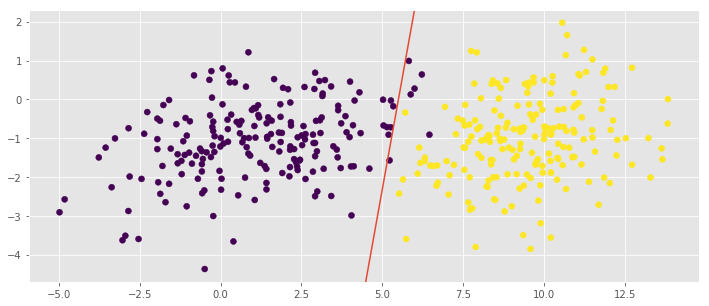

In [180]:
np.random.seed(0)

C1 = np.array([[1., -0.7], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

clf = MySGDClassifier(batch_generator, C=10, alpha=0.01, max_epoch=10)
clf.fit(X, y)
y_pred = clf.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('tight')
plot_decision_boundary(clf)

In [181]:
def loss_means(clf, N):
    loss_log = np.array(clf.errors_log['loss'])
    means = []
    for batch in (loss_log[i: i + N] for i in range(0, len(loss_log), N)):
        m = batch[(batch != np.inf)
                  & (batch != -np.inf)
                  & (batch != np.nan)].mean()
        means.append(m)
    return np.array(means)

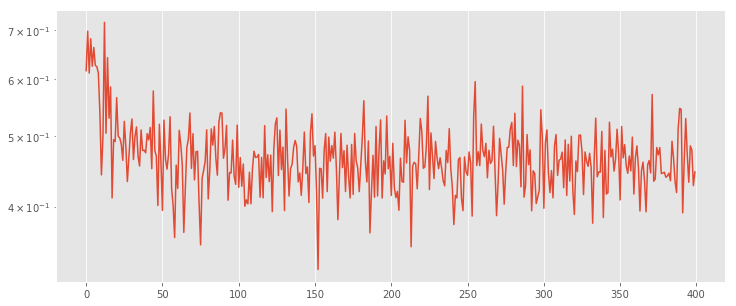

In [182]:
plt.plot(loss_means(clf, 10))
plt.yscale('log')

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [183]:
from sklearn.datasets import make_classification

In [221]:
X, y = make_classification(n_samples=100000, n_features=10,
                                     n_informative=4, n_redundant=0,
                                     random_state=123, class_sep=1.0,
                                     n_clusters_per_class=1)

Покажите сходимость вашего метода на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [185]:
# from sklearn.model_selection import train_test_split
# X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=0.1)

In [222]:
alpha_list = np.logspace(-1, -4, 4)
clf_list = []
for alpha in alpha_list:
    clf = MySGDClassifier(batch_generator, C=10,
                          alpha=alpha, max_epoch=2).fit(X, y)
    clf_list.append(clf)

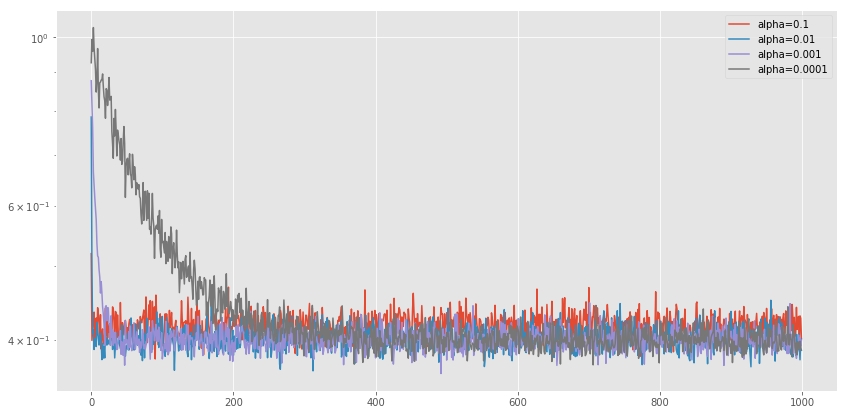

In [223]:
plt.figure(figsize=(14, 7))
for alpha, clf in zip(alpha_list, clf_list):
    plt.plot(loss_means(clf, len(X) // 500), label=f"alpha={alpha}")
plt.yscale('log')
plt.legend()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Примерно 0.001, ибо при очень маленьких alpha алгоритм может не успеть сойтись за выбранное число эпох, а при больших alpha будет сильнее колебаться вокруг минимума.

Изобразите график среднего значения весов модели в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [224]:
C_list = np.logspace(3, -3, 10)
clf_list_C = []
for C in C_list:
    clf = MySGDClassifier(batch_generator, C=C,
                          alpha=0.0001, max_epoch=3).fit(X, y)
    clf_list_C.append(clf)

([<matplotlib.axis.XTick at 0x7fc8835e9748>,
 <a list of 10 Text xticklabel objects>)

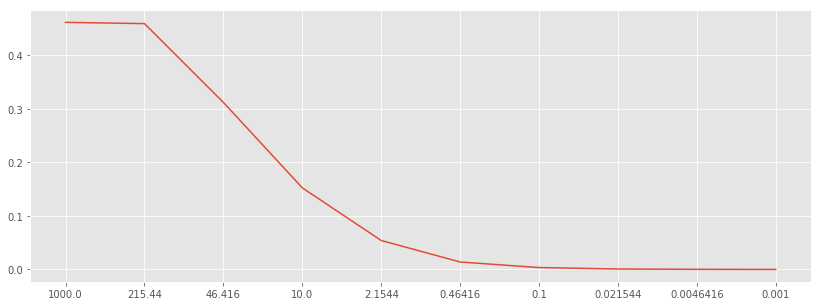

In [225]:
plt.figure(figsize=(14, 5))
w_means = [np.abs(clf.weights).mean() for clf in clf_list_C]
plt.plot(w_means)
plt.xticks(np.arange(len(w_means)), [f"{C:.5}" for C in C_list])

Довольны ли Вы, насколько сильно уменьшились Ваши веса? Если нет, то как можно было бы уменьшать их еще сильнее?

Ещё как.

# Боевое применение (2  балла)

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная онлайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

In [206]:
# Загрузка данных для обучения
filepath = 'trainingData_tabular/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [207]:
df_data.head(10).T

,0,1,2,3,4,5,6,7,8,9
gamestate_id,4687346,3270826,3189487,4098946,2661127,2993360,4378268,3774658,3956442,2958739
decision,1,1,1,1,0,0,0,1,1,1
turn,14,7,5,8,13,13,9,2,12,10
opponent.armor,0,0,3,0,0,0,0,0,2,0
opponent.attack,0,0,0,0,0,0,0,0,0,0
opponent.hero_card_id,798,754,612,390,25,612,612,390,1235,1235
opponent.hp,5,22,29,26,30,26,20,30,18,16
opponent.special_skill_used,0,0,0,0,0,0,0,0,0,0
opponent.weapon_durability,0,0,0,0,0,0,0,0,0,0
opponent.crystals_all,10,6,4,7,10,10,9,1,10,9


In [208]:
print(sorted(df_data["opponent.hero_card_id"].unique()))
print(sorted(df_data["player.hero_card_id"].unique()))

[25, 326, 390, 494, 612, 754, 798, 981, 1235]
[25, 326, 390, 494, 612, 754, 798, 981, 1235]


In [209]:
# Распределение классов
df_data.decision.mean()
# Примерно поровну

0.504702

## Обучение модели

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы. (Вы точно понимаете, зачем это нужно сделать? Если нет, спросите обязательно преподавателя!)
* Стандартизируйте признаки с помощью `StandartScaller` из sklearn (Вы точно понимаете, зачем это нужно сделать? Если нет, спросите обязательно преподавателя!)
* Обучите модель, подбирая параметры на отложенном контроле

In [210]:
def preprocess(df):
    # для удобства
    df_data = df.copy()
    df_data.columns = df_data.columns.str.replace('.', '_')
    df_data = df_data.set_index('gamestate_id')
    df_data.index = df_data.index.astype('int')

    df_t1 = pd.get_dummies(df_data.opponent_hero_card_id)
    df_t1.columns = df_t1.columns.astype('str')
    df_t1.rename({ident: "o_hcid_" + ident for ident in df_t1.columns},
                 axis=1, inplace=True)

    df_t2 = pd.get_dummies(df_data.player_hero_card_id)
    df_t2.columns = df_t2.columns.astype('str')
    df_t2.rename({ident: "p_hcid_" + ident for ident in df_t2.columns},
                 axis=1, inplace=True)
    df_data = pd.concat((df_data, df_t1, df_t2), axis=1)

    df_data.drop(columns=["opponent_hero_card_id", "player_hero_card_id"],
                 inplace=True)
    return df_data

In [211]:
df_data = preprocess(df_data)
df_data.head(10).T

gamestate_id,4687346,3270826,3189487,4098946,2661127,2993360,4378268,3774658,3956442,2958739
decision,1,1,1,1,0,0,0,1,1,1
turn,14,7,5,8,13,13,9,2,12,10
opponent_armor,0,0,3,0,0,0,0,0,2,0
opponent_attack,0,0,0,0,0,0,0,0,0,0
opponent_hp,5,22,29,26,30,26,20,30,18,16
opponent_special_skill_used,0,0,0,0,0,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10,10,9,1,10,9
opponent_crystals_current,10,6,1,7,1,3,2,1,2,1
opponent_deck_count,11,19,22,17,12,10,17,25,13,16


In [212]:
X_train = df_data.iloc[:, 1:]
y_train = df_data.iloc[:, 0]
X_train.index = np.arange(len(X_train), dtype='int64')
y_train.index = X_train.index

In [217]:
clf = MySGDClassifier(batch_generator, alpha=0.001, C=10, max_epoch=1)
clf.fit(X_train, y_train)

/home/garx/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/garx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


MySGDClassifier(C=10, alpha=0.001,
        batch_generator=<function batch_generator at 0x7fc8a4af4ae8>,
        max_epoch=1)

## Применение модели 
* Подготовьте тестовые данные  к подаче на вход в алгоритму (нужно сделать такие же преобразования, как при обучении)
* Примените модель оцените качество на тесте с помощью меры ROC-AUC (имплментацию взять из sklern.metrics)


In [218]:
# Загрузка данных для тестирования
filepath_test = 'trainingData_tabular/trainingData_tabular_chunk2.csv'
df_test = pd.read_csv(filepath_test, sep=',')
df_test = preprocess(df_test)
X_test = df_test.iloc[:, 1:]
y_test = df_test.iloc[:, 0]
X_test.index = np.arange(len(X_test), dtype='int64')
y_test.index = X_test.index

In [219]:
from sklearn.metrics import roc_auc_score

In [220]:
roc_auc_score(y_test, clf.predict(X_test))

0.6830780680833721

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему линейных моделей и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите основные, на Ваш взгляд,  отличия логистической регрессии от линейной регрессии. Почему, на ваш взгляд, задачу классификации решают логистической, а не линейной регрессией?

***Ваше ответ здесь***: Логистическая регрессия - это на самом деле классификация, а линейная регрессия - регрессия;

Потому что в лин. регрессии стоит совсем другая задача, не понимаю, как приплести сюда классификацию.

* Как Вы думаете, для каких типов задач (объем данных, число признаков, типы признаков) стоит отдавать предпочтение линейным моделям?

***Ваше ответ здесь***: Для тех, где есть линейная разделимость выборки, или хотя бы что-то близкое к ней.

Если число признаков слишком большое, надо его сократить, либо использовать другие модели, ибо сложность растет при увеличении числа признаков. То же самое с объемом данных.

* Пусть на обучении мы имеем выборку размера $N$, число признаков $D$. Чему равна алгоритмическая сложность одного шага градиентного спуска? Cтохастического градиентного спуска?  Сложность предсказания на одном объекте?

***Ваше ответ здесь***:

Шаг град. спуска: $O(N\cdot D^2)$

Шаг SGD: $O(D)$

Предсказание на 1 объекте: $O(D)$

* В чем преимущества стохастического градиентного спуска (в том числе мини-батч) над обычным градиентным спуском? В чем его недостатки? Рассмотрите несколько аспектов $-$ скорость сходимости, необходимость загрузки всех данных в оперативную память, сложность вычисления одного шага.

***Ваше ответ здесь***:

(+):

* не нужно помещать всю выборку в оперативную память

* при одинаковом $M=$ max_epoch, SGD проделает $N\cdot M\cdot D$ действий, а обычный град.спуск - $N\cdot M\cdot D^2$ действий)

(-):

* хуже точность

* сходимость может быть хуже

* Как Вы думаете, при обучении линейной модели с помощью SGD, ошибку на новом объекте стоит считать до итерации спуска на этом объекте или после? Почему Вы так думаете? Возможно, Вам будет интересно ознакомиться с http://hunch.net/~jl/projects/prediction_bounds/thesis/mathml/thesisse44.xml

***Ваше ответ здесь***: После, ибо этот объект модель еще не видела. Это будет более полезная информация, чем ошибка на уже обработанном объекте.

* Как Вы думаете, во времена такого бума нейронных сетей, остаются ли популярными линейные модели, или это уже пережиток прошлого? Почему Вы так думаете?

***Ваше ответ здесь***: Да, ибо лин. модели быстрее, а главное, проще, чем нейросети, хотя, может, и менее точны, но в простых задачах могут быть полезны (ибо во многих задачах технические ограничения не всегда позволяют пользоваться самыми передовыми технологиями)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

***ВАШ ОТЗЫВ ЗДЕСЬ***: Норм, спасибо за объяснение теории